## Step 1: Data Collection and API Integration

### Food-101 Dataset

The **Food-101** dataset is a large-scale collection of food images designed for visual recognition tasks.  
It contains **101 categories** of food, with **1,000 images per class** — 750 for training and 250 for testing.  

Since the dataset was downloaded manually from the official [Food-101 website](https://data.vision.ee.ethz.ch/cvl/datasets_extra/food-101/), the extracted directory structure looks like this:



<pre>

food-101/
├── images/
│   ├── apple_pie/
│   ├── pizza/
│   ├── sushi/
│   └── ...
└── meta/
    ├── train.json
    ├── test.json
    └── classes.txt

</pre>


Each image folder corresponds to a food category (e.g., `pizza`, `sushi`, `apple_pie`).  
The `train.json` and `test.json` files contain mappings of image paths to their corresponding labels.

In [25]:
import json
import os
import pandas as pd

with open('../data/raw/food-101/meta/train.json') as f:
    train_data = json.load(f)
with open('../data/raw/food-101/meta/test.json') as f:
    test_data = json.load(f)

train_list = [(img, label) for label, imgs in train_data.items() for img in imgs]
test_list = [(img, label) for label, imgs in test_data.items() for img in imgs]

train_df = pd.DataFrame(train_list, columns=['image_name', 'label'])
test_df = pd.DataFrame(test_list, columns=['image_name', 'label'])

usda_df = pd.read_csv("../data/raw/usda_food_data.csv")
merged_train = train_df.merge(usda_df, left_on='label', right_on='description', how='left')

merged_train.to_csv("../data/clean/train_cleaned.csv", index=False)
test_df.to_csv("../data/clean/test_cleaned.csv", index=False)

print("Data cleaning complete — saved train_cleaned.csv and test_cleaned.csv")

Data cleaning complete — saved train_cleaned.csv and test_cleaned.csv


In [26]:
train_df = pd.read_csv("../data/clean/train_cleaned.csv")
test_df = pd.read_csv("../data/clean/test_cleaned.csv")

print("Datasets successfully loaded")
print(f"Training set shape: {train_df.shape}")
print(f"Testing set shape: {test_df.shape}")

Datasets successfully loaded
Training set shape: (75750, 10)
Testing set shape: (25250, 2)


In [27]:
print("\nTraining Data Info:")
print(train_df.info())

print("\nFirst 5 rows of Training Data:")
display(train_df.head())

print("\n Number of unique labels (food classes):", train_df['label'].nunique())
print("\n Sample labels:", train_df['label'].unique()[:10])


Training Data Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 75750 entries, 0 to 75749
Data columns (total 10 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   image_name     75750 non-null  object 
 1   label          75750 non-null  object 
 2   query          0 non-null      float64
 3   fdcId          0 non-null      float64
 4   description    0 non-null      float64
 5   dataType       0 non-null      float64
 6   calories       0 non-null      float64
 7   protein        0 non-null      float64
 8   fat            0 non-null      float64
 9   carbohydrates  0 non-null      float64
dtypes: float64(8), object(2)
memory usage: 5.8+ MB
None

First 5 rows of Training Data:


,image_name,label,query,fdcId,description,dataType,calories,protein,fat,carbohydrates
0,churros/1004234,churros,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,churros/1013460,churros,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,churros/1016791,churros,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,churros/102100,churros,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,churros/1025494,churros,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN



 Number of unique labels (food classes): 101

 Sample labels: ['churros' 'hot_and_sour_soup' 'samosa' 'sashimi' 'pork_chop'
 'spring_rolls' 'panna_cotta' 'beef_tartare' 'greek_salad' 'foie_gras']


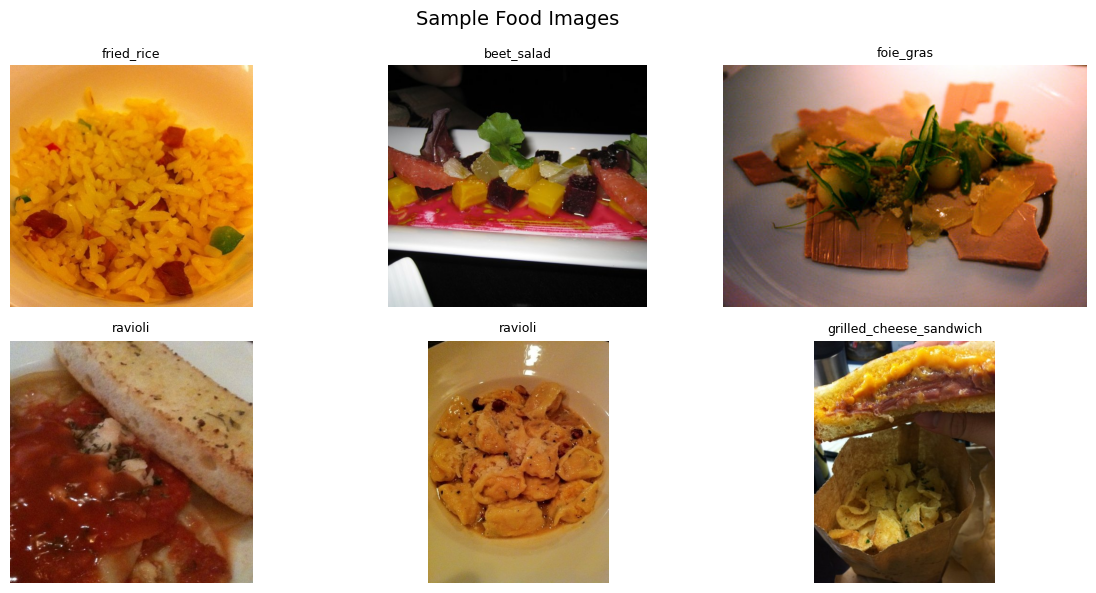

In [28]:
import matplotlib.pyplot as plt
from PIL import Image

def show_sample_images(df, base_path="../data/raw/food-101/images", n=6):
    sample_rows = df.sample(n)
    fig, axes = plt.subplots(2, n//2, figsize=(12, 6))
    axes = axes.flatten()

    for i, (_, row) in enumerate(sample_rows.iterrows()):
        img_path = os.path.join(base_path, f"{row['image_name']}.jpg")
        if os.path.exists(img_path):
            img = Image.open(img_path)
            axes[i].imshow(img)
            axes[i].set_title(row['label'], fontsize=9)
            axes[i].axis("off")
        else:
            axes[i].text(0.5, 0.5, "Image not found", ha='center', va='center')
            axes[i].set_axis_off()

    plt.suptitle("Sample Food Images", fontsize=14)
    plt.tight_layout()
    plt.show()

show_sample_images(train_df)

In [29]:
import tensorflow as tf

IMG_SIZE = 128
BATCH_SIZE = 32

train_df = pd.read_csv("../data/clean/train_cleaned.csv")
test_df = pd.read_csv("../data/clean/test_cleaned.csv")

def load_and_preprocess_image(path):
    image = tf.io.read_file(path)
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.resize(image, [IMG_SIZE, IMG_SIZE])
    image = image / 255.0
    return image

def get_image_path(image_name):
    return os.path.join("../data/raw/food-101/images", image_name + ".jpg")

train_df["image_path"] = train_df["image_name"].apply(get_image_path)

train_ds = tf.data.Dataset.from_tensor_slices((train_df["image_path"], train_df["label"]))
train_ds = train_ds.map(lambda x, y: (load_and_preprocess_image(x), y))
train_ds = train_ds.shuffle(1000).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

---

### USDA FoodData Central API Integration

To enhance the dataset with **nutritional information**, we integrated the **USDA FoodData Central API**, a public database providing nutrient composition data for thousands of food items.

The following Python code demonstrates how the API was accessed and converted into a CSV file (`usda_food_data.csv`):

In [30]:
food_101_labels = sorted(set([
    "apple_pie","baby_back_ribs","baklava","beef_carpaccio","beef_tartare",
    "beet_salad","beignets","bibimbap","bread_pudding","breakfast_burrito",
    "bruschetta","caesar_salad","cannoli","caprese_salad","carrot_cake",
    "ceviche","cheesecake","cheese_plate","chicken_curry","chicken_quesadilla",
    "chicken_wings","chocolate_cake","chocolate_mousse","churros","clam_chowder",
    "club_sandwich","crab_cakes","creme_brulee","croque_madame","cup_cakes",
    "deviled_eggs","donuts","dumplings","edamame","eggs_benedict","escargots",
    "falafel","filet_mignon","fish_and_chips","foie_gras","french_fries",
    "french_onion_soup","french_toast","fried_calamari","fried_rice","frozen_yogurt",
    "garlic_bread","gnocchi","greek_salad","grilled_cheese_sandwich","grilled_salmon",
    "guacamole","gyoza","hamburger","hot_and_sour_soup","hot_dog","huevos_rancheros",
    "hummus","ice_cream","lasagna","lobster_bisque","lobster_roll_sandwich","macaroni_and_cheese",
    "macarons","miso_soup","mussels","nachos","omelette","onion_rings","oysters",
    "pad_thai","paella","pancakes","panna_cotta","peking_duck","pho","pizza",
    "pork_chop","poutine","prime_rib","pulled_pork_sandwich","ramen","ravioli",
    "red_velvet_cake","risotto","samosa","sashimi","scallops","seaweed_salad",
    "shrimp_and_grits","spaghetti_bolognese","spaghetti_carbonara","spring_rolls",
    "steak","strawberry_shortcake","sushi","tacos","takoyaki","tiramisu","tuna_tartare","waffles"
]))

In [31]:
synonyms = {
    
    "beef_carpaccio": "raw beef slices",
    "beef_tartare": "steak tartare",
    "bibimbap": "korean rice bowl",
    "club_sandwich": "turkey sandwich",
    "croque_madame": "ham and cheese sandwich",
    "fish_and_chips": "fried fish with fries",
    "foie_gras": "duck liver pate",
    "gyoza": "dumplings",
    "lobster_roll_sandwich": "lobster sandwich",
    "omelette": "egg omelet",
    "oysters": "raw oysters",
    "pho": "vietnamese soup",
    "pork_chop": "grilled pork chop",
    "poutine": "french fries with gravy",
    "prime_rib": "roast beef",
    "spaghetti_bolognese": "meat sauce spaghetti",
    "spring_rolls": "vegetable rolls",
    "sushi": "japanese sushi",
    "tacos": "mexican tacos",
    "takoyaki": "octopus balls",
    "tuna_tartare": "raw tuna",

    #Additional enhanced entries (NEW)
    "beef_carpaccio_alt": "thinly sliced raw beef appetizer",
    "bibimbap_alt": "korean mixed rice bowl with vegetables and egg",
    "club_sandwich_alt": "multi layer chicken bacon sandwich",
    "croque_madame_alt": "grilled ham and cheese sandwich with fried egg",
    "fish_and_chips_alt": "battered fried fish served with potato fries",
    "foie_gras_alt": "goose liver pate french delicacy",
    "omelette_alt": "fluffy egg omelet with cheese",
    "oysters_alt": "steamed oysters shellfish",
    "pho_alt": "beef noodle soup vietnamese",
    "pork_chop_alt": "fried pork meat with bone",
    "poutine_alt": "canadian french fries with cheese curds and gravy",
    "prime_rib_alt": "slow roasted beef rib cut",
    "spring_rolls_alt": "crispy fried vegetable rolls",
    "sushi_alt": "japanese rice rolls with fish",
    "tacos_alt": "mexican corn tortilla with beef and vegetables",
    "takoyaki_alt": "japanese octopus dough balls",
    "tuna_tartare_alt": "minced raw tuna appetizer",

    #Some additional tricky matches that USDA may describe differently
    "ramen": "japanese noodle soup",
    "paella": "spanish seafood rice",
    "samosa": "indian fried pastry with potato filling",
    "ceviche": "raw fish marinated in lemon juice",
    "panna_cotta": "italian milk dessert",
    "beignets": "fried french dough pastry",
    "bruschetta": "grilled bread with tomato topping",
    "guacamole": "avocado dip",
    "falafel": "fried chickpea balls",
    "lasagna": "layered pasta with cheese and meat sauce",
    "fried_rice": "stir fried rice with egg and vegetables"
}


In [32]:
import requests
import pandas as pd
import time

api_key = "cPZExQIH2MXPTmWaxWVVLnN2Nz4tlpjQihbcYZCy"
base_url = "https://api.nal.usda.gov/fdc/v1/foods/search"

foods = []

for item in food_101_labels:
    query = item.replace("_", " ")
    params = {"query": query, "pageSize": 5, "api_key": api_key}
    response = requests.get(base_url, params=params).json()
    print(f"Fetching {query} ...")
    if "foods" in response:
        for food in response["foods"]:
            nutrients = {nutr["nutrientName"]: nutr["value"] for nutr in food.get("foodNutrients", [])}
            foods.append({
                "query": query,
                "fdcId": food.get("fdcId"),
                "description": food.get("description"),
                "dataType": food.get("dataType"),
                "calories": nutrients.get("Energy", None),
                "protein": nutrients.get("Protein", None),
                "fat": nutrients.get("Total lipid (fat)", None),
                "carbohydrates": nutrients.get("Carbohydrate, by difference", None)
            })
    time.sleep(0.3)

usda_df = pd.DataFrame(foods)
usda_df.drop_duplicates(subset=["description"], inplace=True)
usda_df.to_csv("../data/raw/usda_food_data.csv", index=False)

print(f"Saved {len(usda_df)} food entries for 101 categories to ../data/raw/usda_food_data.csv")

Fetching apple pie ...
Fetching baby back ribs ...
Fetching baklava ...
Fetching beef carpaccio ...
Fetching beef tartare ...
Fetching beet salad ...
Fetching beignets ...
Fetching bibimbap ...
Fetching bread pudding ...
Fetching breakfast burrito ...
Fetching bruschetta ...
Fetching caesar salad ...
Fetching cannoli ...
Fetching caprese salad ...
Fetching carrot cake ...
Fetching ceviche ...
Fetching cheese plate ...
Fetching cheesecake ...
Fetching chicken curry ...
Fetching chicken quesadilla ...
Fetching chicken wings ...
Fetching chocolate cake ...
Fetching chocolate mousse ...
Fetching churros ...
Fetching clam chowder ...
Fetching club sandwich ...
Fetching crab cakes ...
Fetching creme brulee ...
Fetching croque madame ...
Fetching cup cakes ...
Fetching deviled eggs ...
Fetching donuts ...
Fetching dumplings ...
Fetching edamame ...
Fetching eggs benedict ...
Fetching escargots ...
Fetching falafel ...
Fetching filet mignon ...
Fetching fish and chips ...
Fetching foie gras ..

In [33]:
df = pd.read_csv("../data/raw/usda_food_data.csv")
print("Total entries:", len(df))
print("Unique foods:", df['query'].nunique())
df.head()

Total entries: 327
Unique foods: 99


,query,fdcId,description,dataType,calories,protein,fat,carbohydrates
0,apple pie,2288447,APPLE PIE,Branded,354.0,1.77,15.00,54.00
1,baby back ribs,1457876,BABY BACK RIBS,Branded,170.0,18.80,9.82,0.00
2,baby back ribs,2134922,"BABY BACK RIBS POTATO CHIPS, BABY BACK RIBS",Branded,536.0,7.14,32.10,57.10
3,baklava,2708044,Baklava,Survey (FNDDS),440.0,6.58,29.34,37.55
4,baklava,2218273,BAKLAVA,Branded,514.0,5.41,40.50,37.80


In [34]:
import pandas as pd
from rapidfuzz import process, fuzz
import re

# Load USDA data
usda_df = pd.read_csv("../data/raw/usda_food_data.csv")

# Helper function: normalize text for matching
def normalize_text(text):
    text = text.lower()
    text = re.sub(r'[^a-z\s]', '', text)
    return re.sub(r'\s+', ' ', text).strip()

# Normalize USDA descriptions
usda_df["normalized_description"] = usda_df["description"].astype(str).apply(normalize_text)
usda_names = usda_df["normalized_description"].tolist()

# Food-101 categories
food_101_labels = sorted(set([
    "apple_pie","baby_back_ribs","baklava","beef_carpaccio","beef_tartare",
    "beet_salad","beignets","bibimbap","bread_pudding","breakfast_burrito",
    "bruschetta","caesar_salad","cannoli","caprese_salad","carrot_cake",
    "ceviche","cheesecake","cheese_plate","chicken_curry","chicken_quesadilla",
    "chicken_wings","chocolate_cake","chocolate_mousse","churros","clam_chowder",
    "club_sandwich","crab_cakes","creme_brulee","croque_madame","cup_cakes",
    "deviled_eggs","donuts","dumplings","edamame","eggs_benedict","escargots",
    "falafel","filet_mignon","fish_and_chips","foie_gras","french_fries",
    "french_onion_soup","french_toast","fried_calamari","fried_rice","frozen_yogurt",
    "garlic_bread","gnocchi","greek_salad","grilled_cheese_sandwich","grilled_salmon",
    "guacamole","gyoza","hamburger","hot_and_sour_soup","hot_dog","huevos_rancheros",
    "hummus","ice_cream","lasagna","lobster_bisque","lobster_roll_sandwich","macaroni_and_cheese",
    "macarons","miso_soup","mussels","nachos","omelette","onion_rings","oysters",
    "pad_thai","paella","pancakes","panna_cotta","peking_duck","pho","pizza",
    "pork_chop","poutine","prime_rib","pulled_pork_sandwich","ramen","ravioli",
    "red_velvet_cake","risotto","samosa","sashimi","scallops","seaweed_salad",
    "shrimp_and_grits","spaghetti_bolognese","spaghetti_carbonara","spring_rolls",
    "steak","strawberry_shortcake","sushi","tacos","takoyaki","tiramisu","tuna_tartare","waffles"
]))

# Synonyms for better matching
synonyms = {
    
    "beef_carpaccio": "raw beef slices",
    "beef_tartare": "steak tartare",
    "bibimbap": "korean rice bowl",
    "club_sandwich": "turkey sandwich",
    "croque_madame": "ham and cheese sandwich",
    "fish_and_chips": "fried fish with fries",
    "foie_gras": "duck liver pate",
    "gyoza": "dumplings",
    "lobster_roll_sandwich": "lobster sandwich",
    "omelette": "egg omelet",
    "oysters": "raw oysters",
    "pho": "vietnamese soup",
    "pork_chop": "grilled pork chop",
    "poutine": "french fries with gravy",
    "prime_rib": "roast beef",
    "spaghetti_bolognese": "meat sauce spaghetti",
    "spring_rolls": "vegetable rolls",
    "sushi": "japanese sushi",
    "tacos": "mexican tacos",
    "takoyaki": "octopus balls",
    "tuna_tartare": "raw tuna",

    #Additional enhanced entries (NEW)
    "beef_carpaccio_alt": "thinly sliced raw beef appetizer",
    "bibimbap_alt": "korean mixed rice bowl with vegetables and egg",
    "club_sandwich_alt": "multi layer chicken bacon sandwich",
    "croque_madame_alt": "grilled ham and cheese sandwich with fried egg",
    "fish_and_chips_alt": "battered fried fish served with potato fries",
    "foie_gras_alt": "goose liver pate french delicacy",
    "omelette_alt": "fluffy egg omelet with cheese",
    "oysters_alt": "steamed oysters shellfish",
    "pho_alt": "beef noodle soup vietnamese",
    "pork_chop_alt": "fried pork meat with bone",
    "poutine_alt": "canadian french fries with cheese curds and gravy",
    "prime_rib_alt": "slow roasted beef rib cut",
    "spring_rolls_alt": "crispy fried vegetable rolls",
    "sushi_alt": "japanese rice rolls with fish",
    "tacos_alt": "mexican corn tortilla with beef and vegetables",
    "takoyaki_alt": "japanese octopus dough balls",
    "tuna_tartare_alt": "minced raw tuna appetizer",

    #Some additional tricky matches that USDA may describe differently
    "ramen": "japanese noodle soup",
    "paella": "spanish seafood rice",
    "samosa": "indian fried pastry with potato filling",
    "ceviche": "raw fish marinated in lemon juice",
    "panna_cotta": "italian milk dessert",
    "beignets": "fried french dough pastry",
    "bruschetta": "grilled bread with tomato topping",
    "guacamole": "avocado dip",
    "falafel": "fried chickpea balls",
    "lasagna": "layered pasta with cheese and meat sauce",
    "fried_rice": "stir fried rice with egg and vegetables"
}


# Perform fuzzy matching
matches = []
unmatched = []

for food in food_101_labels:
    query = synonyms.get(food, food.replace("_", " "))
    match = process.extractOne(
        query, usda_names, scorer=fuzz.token_sort_ratio, score_cutoff=75
    )
    if match:
        matches.append((food, match[0], match[1]))  # (food_101_label, matched_usda_name, score)
    else:
        unmatched.append(food)

# --- Display summary ---
print(f"\nMatched {len(matches)} categories out of {len(food_101_labels)}.")
print(f"{len(unmatched)} categories have no match:\n")
print(unmatched[:30])  # display first few unmatched

# --- (Optional) show top matches ---
matches_df = pd.DataFrame(matches, columns=["Food_101_Label", "Matched_USDA_Description", "Match_Score"])
matches_df.sort_values(by="Match_Score", ascending=False).head(15)


Matched 84 categories out of 101.
17 categories have no match:

['beef_carpaccio', 'bibimbap', 'club_sandwich', 'croque_madame', 'fish_and_chips', 'foie_gras', 'omelette', 'oysters', 'pho', 'pork_chop', 'poutine', 'prime_rib', 'spring_rolls', 'sushi', 'tacos', 'takoyaki', 'tuna_tartare']


,Food_101_Label,Matched_USDA_Description,Match_Score
0,apple_pie,apple pie,100.0
49,hot_dog,hot dog,100.0
57,macarons,macarons,100.0
56,macaroni_and_cheese,macaroni and cheese,100.0
54,lobster_bisque,lobster bisque,100.0
53,lasagna,lasagna,100.0
52,ice_cream,ice cream,100.0
51,hummus,hummus,100.0
50,huevos_rancheros,huevos rancheros,100.0
48,hot_and_sour_soup,soup hot and sour,100.0
